**Project 1**

Work in groups of 2-5. Prepare ~10 slides where one slide describes your setup and analysis, main results, challenges/suprises and take-home message.

Everyone should do the first part of the project. You can then choose from one of the three themes for part 2.

For the first part of the project, you will be working on a high-dimensional data from the cancer genom atlas (TCGA). The data matrices contain gene expression (relates to how much of a gene product (protein) is being produced) for 2000 randomly selected genes over 2887 cancer samples. There are 6 types of cancers in this data set. You don't need to know any bio for the project - just think of this as a 6 class data set with 2000 features.

You will notice that the classes are quite imbalanced. There are a lot of breast cancer samples and very few uterine samples, etc.

All of the project themes aim at you exploring how to make a method "crash" in some way - meaning that you illustrate when a particular method or approach would be a bad choice, or simple a situation when things might not work out as hoped for.

For all tasks, you have to repeat the exercise in order to be able to draw conclusions. That is, one single run of a data analysis task or simulation has very limited information so repeat a few times to ensure you are not drawing conclusions based on a random "fluke".

**Part 1 - Dimension reduction and predictive modeling**

*Everyone should do this task.*

High-dimensional data tend to be "data hungry". For some methods, high-dimensionality can results in a large number of parameters having to be estimated and as a consequence you might high estimation variance. It is therefore quite common to try to reduce the dimensionality of the problem prior to modeling. (An alternative to this is filtering where you remove a (possibly large) subset of features before modeling.

In class we have so-far discussed a linear dimension reduction technique, PCA and some basic filtering based on e.g. variance, t or F-tests.

You should explore at least 3 different classifiers of different character, from flexible to rigid (e.g. small k to large k in k-nearest neighbors). Feel free to try any other classifier you like as long as you explain if they are flexible or rigid.

1. Perform cross-validation to select the number of principal components that optimizing predictive performance.
2. Perform cross-validation to select the number features (genes) that optimizing predictive performance.
3. Demonstrate the optimism of training by comparing the difference between training error, cross-validation error after selection of optimal PCs or features, and test error performance. Discuss the difference for the fleixble and rigid classifiers in terms of optimism.
4. Repeat the above for 3 different size training sets and discuss the results.

*Voluntary - something to think about*

1. Can you construct a data set where PCA dimension reduction should improve classification performance?
2. Can you construct a data set where PCA dimension reduction should reduce classification performance?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

In [3]:
##### Load dataset ######
file_path_data = "TCGAdata.txt"
file_path_labels = "TCGAlabels.txt"

df_data = pd.read_csv(
    file_path_data, 
    delim_whitespace=True,  # Use whitespace as the delimiter
    header=0,               # Use the first line as the header
    quotechar='"'           # Specify the quote character used
)

df_labels = pd.read_csv(
    file_path_labels, 
    delim_whitespace=True,  
    header=0,               
    quotechar='"'           
)

df = pd.merge(df_data, df_labels, left_index=True, right_index=True, how='left')

df.head(1)
print(df.shape)

(2887, 2001)


In [23]:
##### Split into train and test set ######
X = df.iloc[:, :-1] #features
y = df.iloc[:, -1] #Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42 )

print(X_train.shape)



##### Section for mislabelling a percentage of y_test #####
# Function to mislabel a percentage of the data
def randomize_labels(labels, percentage=10):
    n_total = len(labels)
    n_change = int(n_total * (percentage / 100))
    indices_to_change = np.random.choice(n_total, n_change, replace=False)
    #print(n_total)

    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Mislabeling logic
    new_labels = labels.copy()
    for index in indices_to_change:
        original_label = labels.iloc[index]
        possible_labels = unique_labels[unique_labels != original_label]
        new_labels.iloc[index] = np.random.choice(possible_labels)
    #print(f"NEW LABELS shape {indices_to_change}")
    return new_labels, indices_to_change

# Randomizing labels in y_test
mislabel_percentage = 1  # Change this as needed
y_train_randomized, indices_change = randomize_labels(y_train, percentage=mislabel_percentage)

# Verify changes
#print("Original labels sample:", y_train.iloc[indices_change])
#print("Randomized labels sample:", y_train_randomized.iloc[indices_change])




"""
#### Checking for variance of the different features ####
# Make sure X_train is a NumPy array
if not isinstance(X_train, np.ndarray):
    X_train = np.array(X_train)

print("Shape of X_train:", X_train.shape)

# Setting up the dimensions of the grid
rows = 10  # Number of subplot rows
cols = 10  # Number of subplot columns

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
fig.tight_layout(pad=5.0)

# Plot a subset of features to avoid overload
# You can adjust rows and cols above based on how many plots you want to see at a time
for i, ax in enumerate(axes.flatten()):
    if i < X_train.shape[1]:  # Check if the column index exists in X_train
        ax.hist(X_train[:, i], bins=50, density=False, alpha=0.5)
        ax.set_title(f"Feature {i+1}")
    else:
        ax.axis('off')  # Turn off axis if no more data columns

plt.show()

def check_normality(data, columns, alpha=0.05):
    results = {}
    for i, col in enumerate(columns):
        feature_data = data[:, i]

        # Visual Inspection: Histogram
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.hist(feature_data, bins=30, alpha=0.75, color='blue', density=True)
        plt.title(f'Histogram of {col}')

        # Visual Inspection: Q-Q plot
        plt.subplot(1, 2, 2)
        stats.probplot(feature_data, dist="norm", plot=plt)
        plt.title(f'Q-Q plot of {col}')

        plt.tight_layout()
        plt.show()

        # Statistical Test: Shapiro-Wilk
        stat, p_value = stats.shapiro(feature_data)
        results[col] = {'Shapiro-Wilk Statistic': stat, 'p-value': p_value, 'Normal': p_value > alpha}

    return results

# Assuming X_train is your data and it's a NumPy array
columns = [f"Feature {i+1}" for i in range(X_train.shape[1])]
normality_results = check_normality(X_train, columns)

# Print results
for feature, result in normality_results.items():
    print(f"{feature}: {'Normal' if result['Normal'] else 'Not Normal'} - p-value: {result['p-value']:.4f}")
"""



(1732, 2000)
1732
NEW LABELS shape [ 758  952  670  795 1501 1400  504 1047  849  300  862  170  313  876
 1173 1358   78]
Original labels sample: 2059     LU
1255     BC
371      BC
1640     OV
1735     LU
191      BC
2462     KI
578      BC
2878      U
1790     LU
2052     LU
2411     KI
1195     BC
898      BC
39      GBM
51      GBM
79      GBM
Name: x, dtype: object
Randomized labels sample: 2059    GBM
1255     LU
371      OV
1640      U
1735    GBM
191      LU
2462     OV
578       U
2878     KI
1790     KI
2052     KI
2411     OV
1195     LU
898     GBM
39       OV
51       OV
79       LU
Name: x, dtype: object


'\n#### Checking for variance of the different features ####\n# Make sure X_train is a NumPy array\nif not isinstance(X_train, np.ndarray):\n    X_train = np.array(X_train)\n\nprint("Shape of X_train:", X_train.shape)\n\n# Setting up the dimensions of the grid\nrows = 10  # Number of subplot rows\ncols = 10  # Number of subplot columns\n\nfig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))\nfig.tight_layout(pad=5.0)\n\n# Plot a subset of features to avoid overload\n# You can adjust rows and cols above based on how many plots you want to see at a time\nfor i, ax in enumerate(axes.flatten()):\n    if i < X_train.shape[1]:  # Check if the column index exists in X_train\n        ax.hist(X_train[:, i], bins=50, density=False, alpha=0.5)\n        ax.set_title(f"Feature {i+1}")\n    else:\n        ax.axis(\'off\')  # Turn off axis if no more data columns\n\nplt.show()\n\ndef check_normality(data, columns, alpha=0.05):\n    results = {}\n    for i, col in enumerate(columns):\n  

In [5]:
##### Center and Normalize ######

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

(-1.0, 200.0)

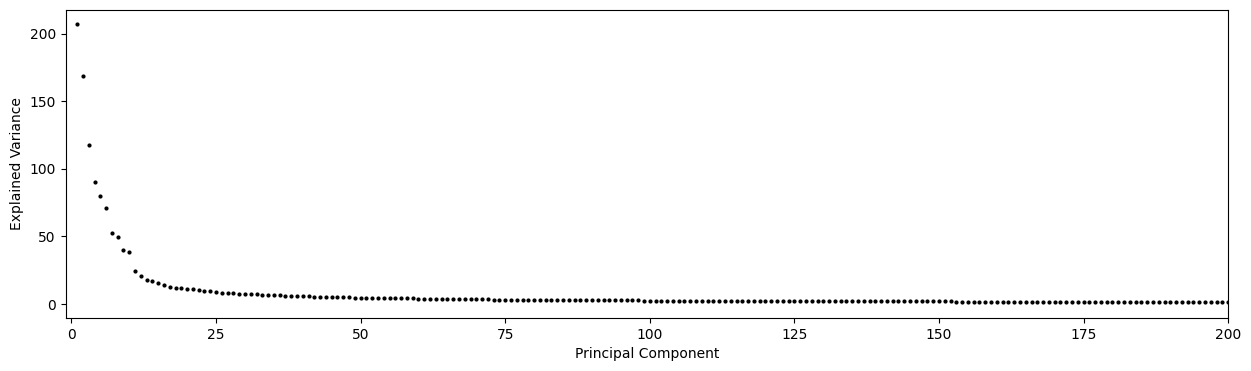

In [9]:
##### Scree plot to visualize effect of num of PC ######
pca = PCA().fit(X_train)

fig = plt.figure(figsize=(15, 4))
ax = fig.gca()

ax.plot(np.arange(1, len(pca.explained_variance_) + 1), pca.explained_variance_, 'ok', markersize=2)
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance")
ax.set_xlim([-1,200])

In [7]:
####### Cross-validation to find optimal num of PC #######

def cross_val_pca(classifier):
    # Define the cross-validation and the range of components to test
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    component_range = range(1, 30)  # Up to 50 components, for example

    # Store average scores for each number of components
    scores = []

    for n_components in component_range:
        # Create a PCA object with the current number of components
        pca = PCA(n_components=n_components)
        
        # Create a logistic regression classifier
        #classifier = LogisticRegression(max_iter=10000)  # Increase max_iter
        
        # Make a pipeline combining PCA and the classifier
        pipeline = make_pipeline(pca, classifier)
        
        # Perform cross-validation and store the average score
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, verbose = 1)
        scores.append(np.mean(cv_scores))

    # Find the number of components with the highest average score
    optimal_components = component_range[np.argmax(scores)]

    print(f"Optimal number of components: {optimal_components}, Validation error: {scores[optimal_components]}")

    return optimal_components

def plot(X_test_pca, y_pred):  
    pca = PCA(n_components=2)
    X_test_pca_2d = pca.fit_transform(X_test_pca)
    plt.figure(figsize=(4, 4))

    for i in range(len(y_test)):
        color = 'green' if y_test.iloc[i] == y_pred[i] else 'red'
        plt.scatter(X_test_pca_2d[i][0], X_test_pca_2d[i][1], c=color)

    plt.title('Correct/Incorrect Classifications')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()


####### Evaluate #######
def evaluate(optimal_components, classifier):
    pca = PCA(n_components=optimal_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Fit the model on the PCA-transformed training data
    classifier.fit(X_train_pca, y_train)
    y_pred_train = classifier.predict(X_train_pca)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train, average='weighted')  # Use weighted average for multiclass classification
    precision_train = precision_score(y_train, y_pred_train, average='weighted')  # Use weighted average for multiclass classification
    print(f"Training Accuracy: {accuracy_train}, Recall: {recall_train}, Precision: {precision_train}")


    # Make predictions on the PCA-transformed test data
    predictions = classifier.predict(X_test_pca)
    plot(X_test_pca, predictions)
    # Compute metrics 
    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions, average='weighted')  # Use weighted average for multiclass classification
    precision = precision_score(y_test, predictions, average='weighted', zero_division=0)  # Use weighted average for multiclass classification
    print(f"Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}")



In [8]:
for k in [5, 100, 200]:
    print(f"========== k: {k} ==========")
    classifier = KNeighborsClassifier(n_neighbors=k)
    optimal_components = cross_val_pca(classifier)
    evaluate(optimal_components, classifier)

print(f"========== LR ==========")
classifier = LogisticRegression(max_iter=10000) 
optimal_components = cross_val_pca(classifier)
evaluate(optimal_components, classifier)
    

========== k: 5 ==========


KeyboardInterrupt: 

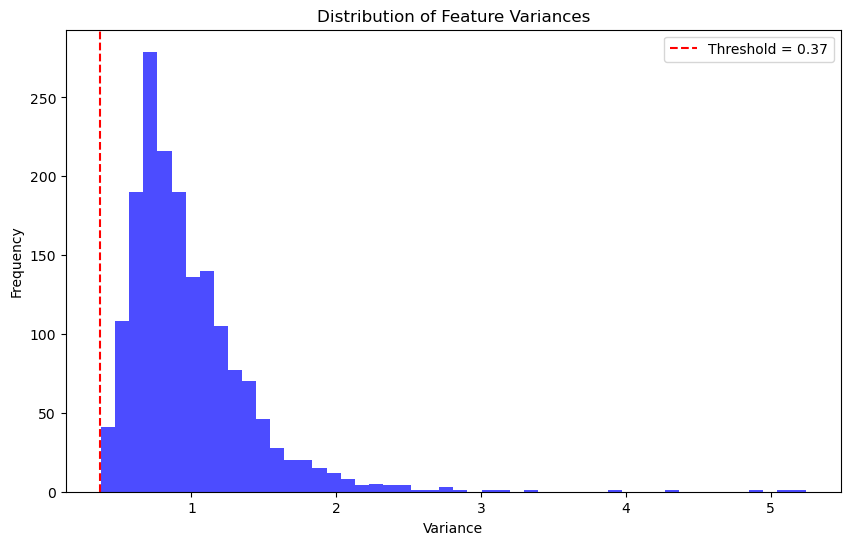

In [ ]:
import matplotlib.pyplot as plt

# Calculate the variance of each feature
feature_variances = np.var(X_train, axis=1)
threshold = 0.37
# Plotting the distribution of feature variances
plt.figure(figsize=(10, 6))
plt.hist(feature_variances, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.axvline(x=threshold, color='red', linestyle='dashed', label=f'Threshold = {threshold}')
plt.legend()
plt.show()


In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Example threshold: Variance with a cutoff of 0.1
selector = VarianceThreshold(threshold=0.9)
X_train_thresholded = selector.fit_transform(X_train)

print("Original feature count:", X_train.shape[1])
print("Reduced feature count:", X_train_thresholded.shape[1])

Original feature count: 2000
Reduced feature count: 1982


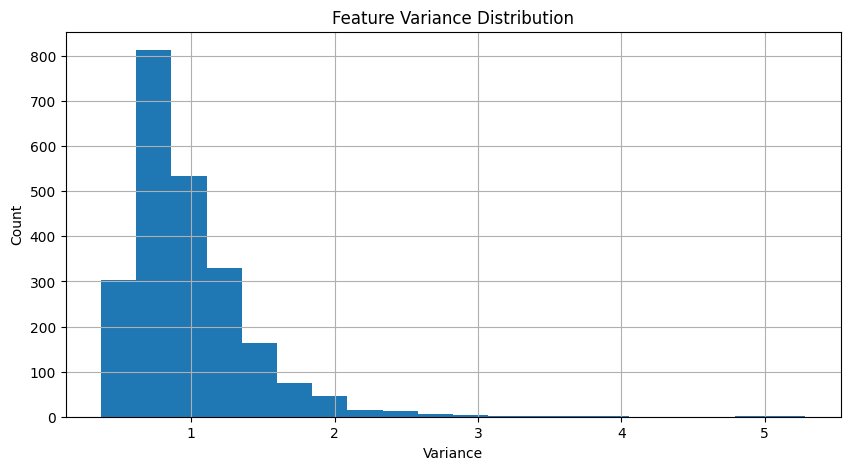

Random Forest Classification Report:

              precision    recall  f1-score   support

         GBM       0.98      1.00      0.99       249
          BC       1.00      1.00      1.00        32
          OV       1.00      0.98      0.99       124
          LU       0.99      0.99      0.99       111
          KI       1.00      1.00      1.00        52
           U       0.88      0.70      0.78        10

    accuracy                           0.99       578
   macro avg       0.97      0.94      0.96       578
weighted avg       0.99      0.99      0.99       578

Class-specific Accuracies: [1.   1.   0.98 0.99 1.   0.7 ]
KNN Classification Report:

              precision    recall  f1-score   support

         GBM       0.99      1.00      0.99       249
          BC       1.00      1.00      1.00        32
          OV       1.00      0.98      0.99       124
          LU       0.99      1.00      1.00       111
          KI       0.98      1.00      0.99        52
       

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

##### IMPORTED CODE FROM anova.py######

# Load data
file_path_data = "TCGAdata.txt"
file_path_labels = "TCGAlabels.txt"
df_data = pd.read_csv(file_path_data, delim_whitespace=True, header=0, quotechar='"')
df_labels = pd.read_csv(
    file_path_labels, delim_whitespace=True, header=0, quotechar='"'
)
df = pd.merge(df_data, df_labels, left_index=True, right_index=True, how="left")

# Split into train and test set
X = df.iloc[:, :-1]  # Features
y = df.iloc[:, -1]  # Labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Plot the variance across all features
feature_variance = np.var(X_train_scaled, axis=1)
plt.figure(figsize=(10, 5))
plt.hist(feature_variance, bins=20)
plt.title("Feature Variance Distribution")
plt.xlabel("Variance")
plt.ylabel("Count")
plt.grid(True)
plt.show()


"""

# Create a VarianceThreshold feature selector
original_feature_count = X_train_scaled.shape[1]
variance_threshold = 0.0
sel = VarianceThreshold(threshold=variance_threshold)
X_train_scaled = sel.fit_transform(X_train_scaled)
X_test_scaled = sel.transform(X_test_scaled)

# Print the number of removed features
removed_features = original_feature_count - X_train_scaled.shape[1]
print(f"Removed {removed_features} features with variance below {variance_threshold}")
"""




# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=3),
}
"""
# Number of features to evaluate
max_features = min(
    100, X_train_scaled.shape[1]
)  # Limit max features to 100 or total features count
feature_range = range(1, max_features + 1, 5)  # Evaluate every 5 features
##### IMPORTED CODE FROM anova.py######


# Prepare to track best performance
best_accuracy = 0
best_k = 0
performance_history = []
"""

# Prepare to track best performance
best_accuracy = 0
best_k = 0
performance_history = []

model=RandomForestClassifier()
model.fit(X_train,y_train)
prediction_random_forest=model.predict(X_test)  #X_test

model2=KNeighborsClassifier(n_neighbors=3)
model2.fit(X_train,y_train)
prediction_knn=model2.predict(X_test)  #X_test

model3=LogisticRegression(max_iter=10000)
model3.fit(X_train,y_train)
prediction_logistic=model3.predict(X_test)  #X_test

# Assuming df is your DataFrame
target_names = ['GBM', 'BC','OV','LU', 'KI', 'U']

# Generate classification report
#y_test
report = classification_report(y_test, prediction_random_forest, target_names=target_names)
print("Random Forest Classification Report:\n")
print(report)
# Alternatively, directly calculate per class metrics from the confusion matrix
cm = confusion_matrix(y_test, prediction_random_forest)
np.set_printoptions(precision=2)
# Calculate accuracy per class
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("Class-specific Accuracies:", class_accuracy)


report2=classification_report(y_test, prediction_knn, target_names=target_names)
print("KNN Classification Report:\n")
print(report2)
cm2 = confusion_matrix(y_test, prediction_knn)
np.set_printoptions(precision=2)
class_accuracy2 = cm2.diagonal() / cm2.sum(axis=1)
print("Class-specific Accuracies:", class_accuracy2)

report3=classification_report(y_test, prediction_logistic, target_names=target_names)
print("Logistic Regression Classification Report:\n")
print(report3)
cm3 = confusion_matrix(y_test, prediction_logistic)
np.set_printoptions(precision=2)
class_accuracy3 = cm3.diagonal() / cm3.sum(axis=1)
print("Class-specific Accuracies:", class_accuracy3)




